In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [139]:
data = pd.read_parquet('data/francetax_processed.parquet')

paris_data = data[data['Libellé commune'] == 'PARIS']

# Ensure the dataset contains the necessary columns
paris_data['Year'] = paris_data['ANNEE']
paris_data['Tax_Revenue'] = paris_data[['TFNB', 'TFB', 'TH']].sum(axis=1)

# Prepare features and target variable
X = paris_data[['Year']]
y = paris_data['Tax_Revenue']

# Split data into training and testing sets (up to 2020 for training, 2021-2022 for testing)
X_train = X[X['Year'] <= 2018]
X_test = X[X['Year'] > 2018]
y_train = y[X['Year'] <= 2018]
y_test = y[X['Year'] > 2018]


# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)
future_years = np.arange(2023, 2033).reshape(-1, 1)
lr_pred_future = lr.predict(future_years)

# XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)
xgb_pred_future = xgb.predict(pd.DataFrame({'Year': future_years.flatten()}))


In [140]:
# Print model performances
print(f"Linear Regression MSE: {mean_squared_error(y_test, lr_pred_test)}")
print(f"XGBoost Regressor MSE: {mean_squared_error(y_test, xgb_pred_test)}")

Linear Regression MSE: 2.82988316148e+17
XGBoost Regressor MSE: 2.7540043890911104e+17


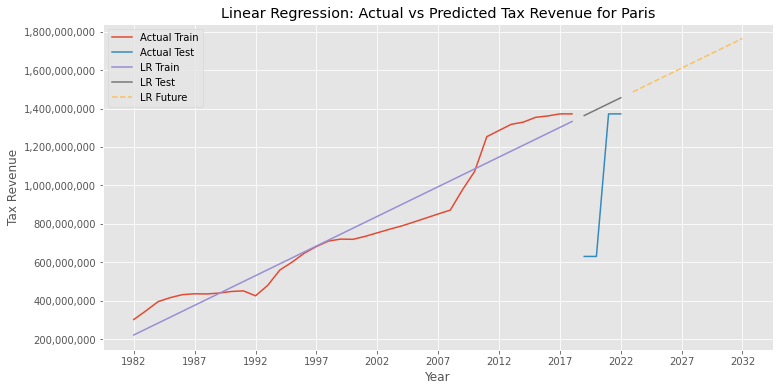

In [141]:
# Linear Regression
plt.figure(figsize=(12,6))
plt.plot(X_train['Year'], y_train, label='Actual Train')
plt.plot(X_test['Year'], y_test, label='Actual Test')
plt.plot(X_train['Year'], lr_pred_train, label='LR Train')
plt.plot(X_test['Year'], lr_pred_test, label='LR Test')
plt.plot(future_years, lr_pred_future, label='LR Future', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted Tax Revenue for Paris')
plt.xlabel('Year')
plt.ylabel('Tax Revenue')
plt.legend()
plt.xticks(np.arange(1982, 2033, step=5))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))


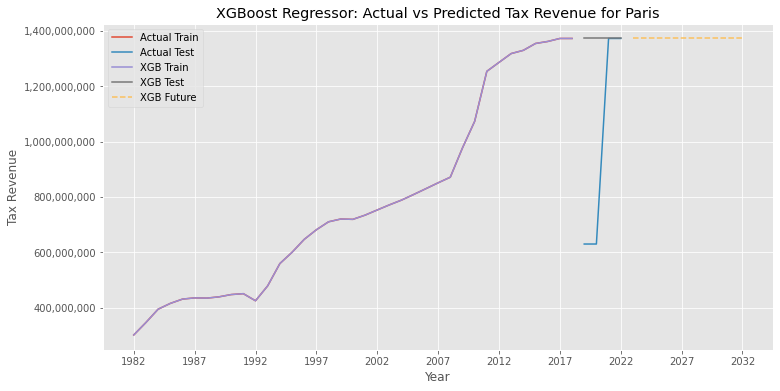

In [142]:
# XGBoost Regressor
plt.figure(figsize=(12,6))
plt.plot(X_train['Year'], y_train, label='Actual Train')
plt.plot(X_test['Year'], y_test, label='Actual Test')
plt.plot(X_train['Year'], xgb_pred_train, label='XGB Train')
plt.plot(X_test['Year'], xgb_pred_test, label='XGB Test')
plt.plot(future_years, xgb_pred_future, label='XGB Future', linestyle='--')
plt.title('XGBoost Regressor: Actual vs Predicted Tax Revenue for Paris')
plt.xlabel('Year')
plt.ylabel('Tax Revenue')
plt.legend()
plt.xticks(np.arange(1982, 2033, step=5))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))


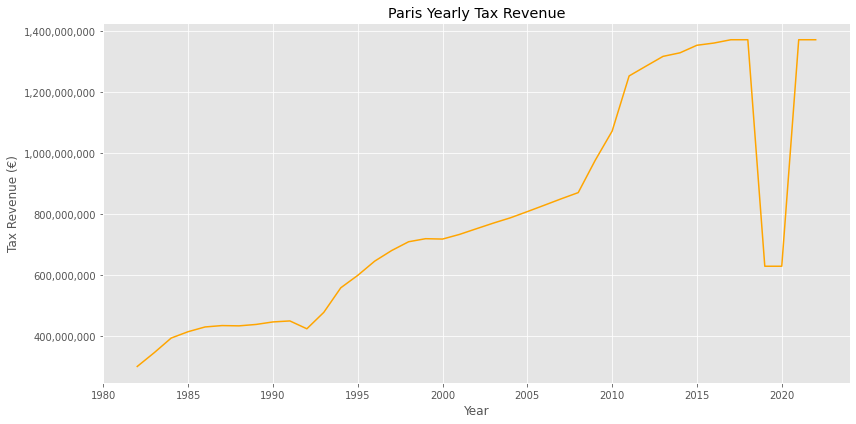

In [100]:
### SARIMA
paris = paris_data.set_index('ANNEE')['TAX_REVENUE']
plt.figure(figsize=(12,6))
plt.plot(paris, linewidth=1.5, color='orange')
plt.title("Paris Yearly Tax Revenue")
plt.xlabel('Year')
plt.ylabel('Tax Revenue (€)')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()



In [101]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('The timeseries is Stationary' if p_value < 0.05 else 'The timeseries is Non-Stationary\n')

print(f'The original time series')
check_stationarity(paris)

print(f'The first differences time series')
check_stationarity(paris.diff(1)[1:])

The original time series
ADF Statistic: 0.9986248529734311
p-value: 0.994251417939351
The timeseries is Non-Stationary

The first differences time series
ADF Statistic: -5.250106343109953
p-value: 6.940939386964819e-06
The timeseries is Stationary


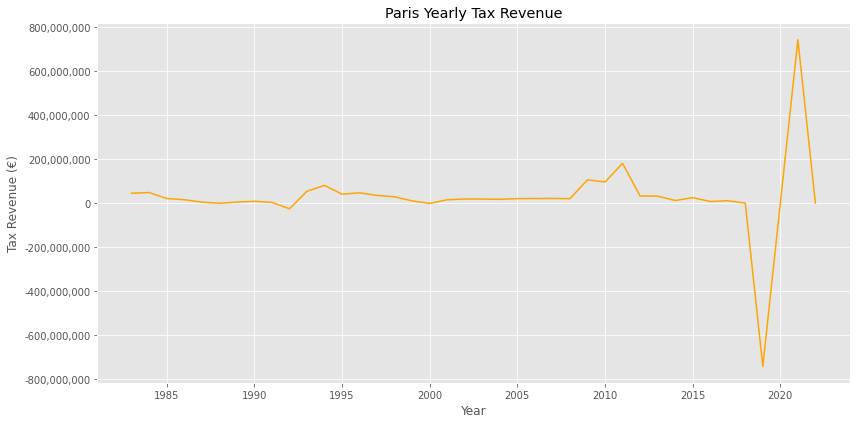

In [102]:
x = paris.diff(1)[1:]

plt.figure(figsize=(12,6))
plt.plot(x, linewidth=1.5, color='orange')
plt.title("Paris Yearly Tax Revenue")
plt.xlabel('Year')
plt.ylabel('Tax Revenue (€)')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

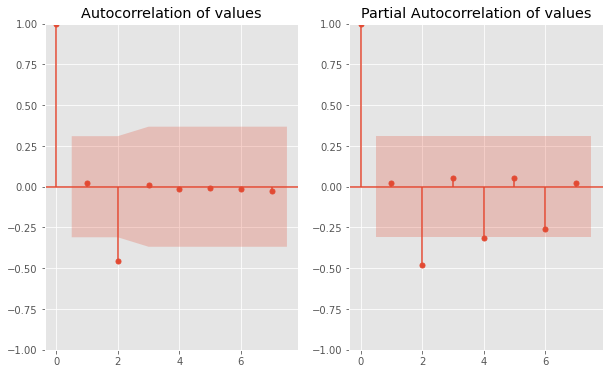

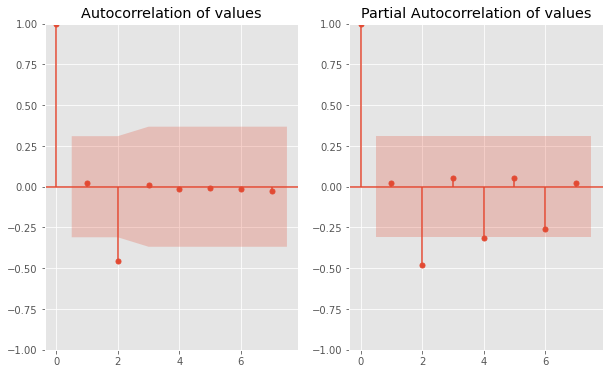

In [103]:
l = 7
_, ax = plt.subplots(1,2, figsize = (10,6))
plot_acf( x, lags=l, ax = ax[0], title = 'Autocorrelation of values')
plot_pacf(x, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

In [104]:
import itertools
ps = range(0, 4) # by partial autocorr
ds = 1
qs = range(0, 4) # by autocorr


parameters = itertools.product(ps, [ds], qs, [0], [0], [0], [0])
parameters_list = list(parameters)
print(len(parameters_list))

16


In [105]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        #'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

In [106]:
%%time
x = paris
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time
n = len(x)
n1 = 12

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

CPU times: total: 3.09 s
Wall time: 5.37 s


In [107]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')

df_out.drop(['P', 'D', 'Q', 'S', 'time'], axis=1,inplace=True)
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae,mse
0,3,1,1,2.016725e+08,9.319909e+16
1,1,1,3,2.019931e+08,9.340724e+16
2,3,1,3,2.025064e+08,9.339734e+16
3,2,1,2,2.026148e+08,9.295294e+16
4,3,1,2,2.041258e+08,9.308253e+16
5,2,1,1,2.043353e+08,9.307443e+16
6,2,1,3,2.065026e+08,9.309546e+16
7,1,1,2,2.066292e+08,9.314530e+16
8,1,1,1,2.364980e+08,7.705553e+16
9,3,1,0,2.402240e+08,7.663304e+16


In [119]:
model = SARIMAX(x, order=(3, 1, 1), seasonal_order=(0, 0, 0, 0))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            TAX_REVENUE   No. Observations:                   41
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -806.059
Date:                Mon, 22 Jul 2024   AIC                           1622.118
Time:                        22:13:30   BIC                           1630.562
Sample:                             0   HQIC                          1625.171
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6090      0.201     -3.034      0.002      -1.002      -0.216
ar.L2         -0.5122      0.180     -2.841      0.004      -0.866      -0.159
ar.L3         -0.2814      0.415     -0.677      0.498      -1.096       0.533
ma.L1          0.9879      0.232      4.266      0.000       0.534       1.442
sigma2      1.989e+16   8.22e-18   2.42e+33      0.000    1.99e+16    1.99e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               501.98
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              10.57   Skew:                            -3.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+49. Standard errors may be unstable.
"""

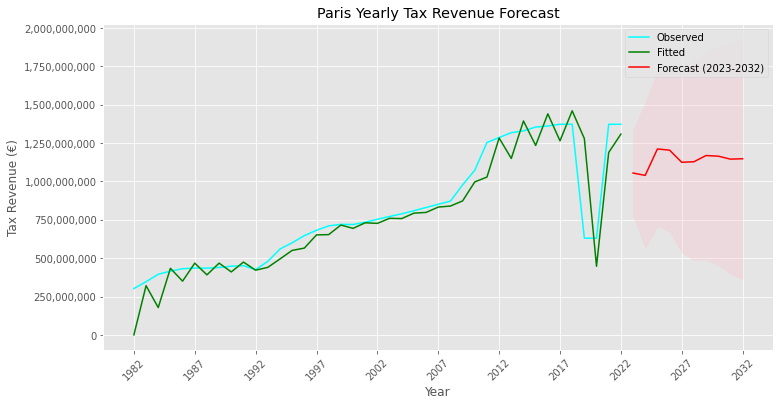

In [157]:
paris_series = paris

fitted_values = fitted_model.fittedvalues

# Forecast the next 10 years
forecast_periods = 10
forecast = fitted_model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Adjust the forecast index
last_year = paris_series.index[-1]
forecast_years = np.arange(last_year + 1, last_year + 1 + forecast_periods)

# Plot the observed, fitted, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(paris_series.index, paris_series.values, label='Observed', color='cyan')
plt.plot(fitted_values.index, fitted_values.values, label='Fitted', color='green')
plt.plot(forecast_years, forecast_mean.values, label='Forecast (2023-2032)', color='red')
plt.fill_between(forecast_years, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Paris Yearly Tax Revenue Forecast")
plt.xlabel("Year")
plt.ylabel("Tax Revenue (€)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend()
plt.xticks(np.arange(1982, 2033, step=5), rotation=45)
plt.grid(True)
plt.show()
